In [250]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
# from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random
plt.style.use('fivethirtyeight')

In [251]:
!cat ~/user_state

# ex.
# Now in use: ccc
# Start time: 03/31 12:00
# Estimated end time(option): 03/31 18:00

Now in use: Zeng	
Start time: 5/19 13:00
Estimated end time(option): 5/19 14:00

Next one who want to use: 
Estimated start time: 
Estimated end time(option): 



In [252]:
!nvidia-smi

Fri May 19 13:12:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090         Off| 00000000:01:00.0 Off |                  Off |
| 30%   48C    P2              100W / 480W|  16220MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [253]:
# Time sequence length and prediction time length
#seed = 55688
#time_seq = 15
#predict_t = 5
#valid_ratio = 0.2
#task = 'classification'

In [254]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 30
predict_t = 10
valid_ratio = 0.2
task = 'classification'

In [255]:
# Setup seed
random.seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "/home/wmnlab/Documents/sheng-ru/chang/model"

# Define DataSet
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single"
dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

train_dates = ['03-26', '04-01']
test_dates = ['04-10']

def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)


# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

def ts_array_create(dirname, dir_list, time_seq):
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        df[columns] = df[columns].replace(0,np.nan)
        df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0); df.replace('-',0)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:];
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:];
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]

    if task == 'classification':
        return X_final, HO(Y_final), split_time # classification
    elif task == 'forecast':
        return X_final, reamin_HO_time(Y_final), split_time # forecast HO
#         return X_final, np.sum(Y_final, axis=1), split_time # forecase loss

print('Loading training data...')
X_train, y_train, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)

print('Loading testing data...')
X_test, y_test, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)

train_data = xgb.DMatrix(X_train_2d, label=y_train)
test_data = xgb.DMatrix(X_test_2d, label=y_test)

GPU 0: NVIDIA GeForce RTX 4090
Loading training data...


  0%|          | 0/116 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/29 [00:00<?, ?it/s]

In [256]:
X_train_2d.shape

(62094, 480)

In [257]:
# train_dir_list, test_dir_list

In [258]:
# Parameters
if task == 'forecast':
    params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'max_depth': 20, 'eval_metric': ['rmse', 'mae'], 'seed': seed}
elif task == 'classification':
    params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'max_depth': 20, 'eta': 0.08, 'gamma': 0.05, 
              'seed': seed,'eval_metric': ['error','logloss','aucpr']}
n = 600

In [259]:
evals_result = {}
model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n,
    evals=[(train_data, 'train'), (test_data, 'valid')],
    evals_result=evals_result,
    early_stopping_rounds=5,
    verbose_eval=False
)



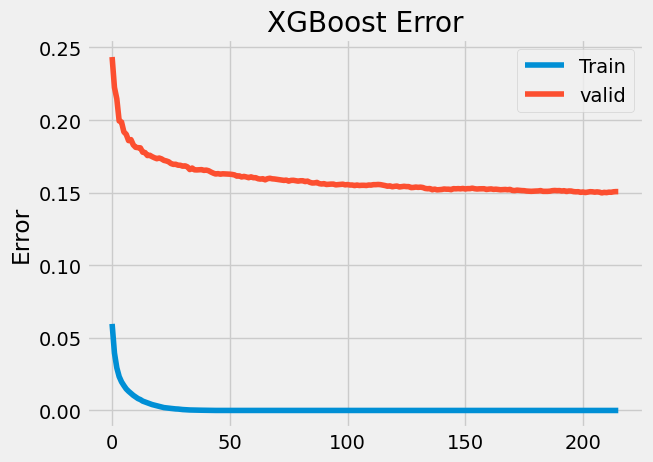

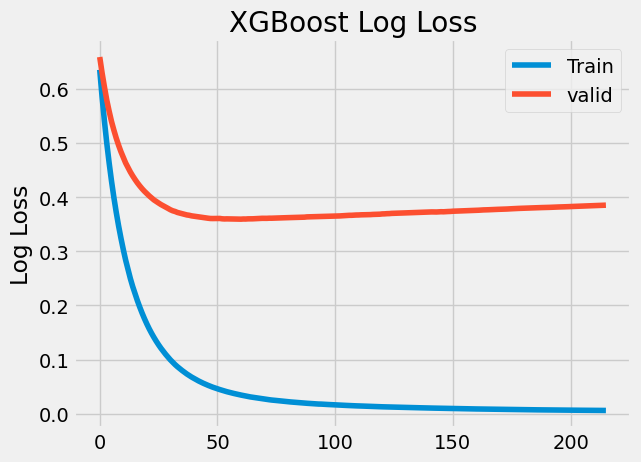

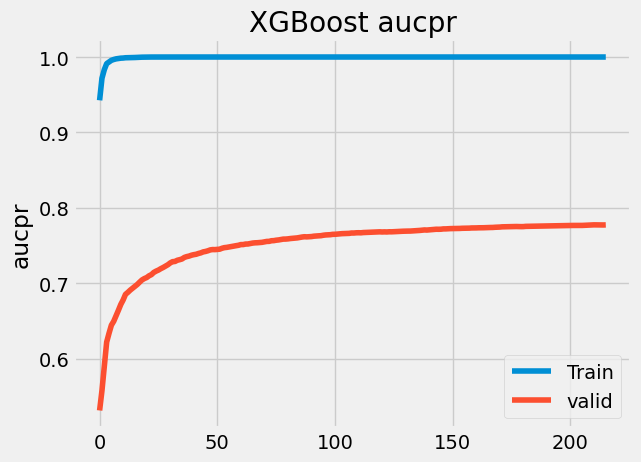

In [260]:
# plot evaluation metrics
epochs = len(evals_result['train']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['error'], label='Train')
ax.plot(x_axis, evals_result['valid']['error'], label='valid')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['logloss'], label='Train')
ax.plot(x_axis, evals_result['valid']['logloss'], label='valid')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['aucpr'], label='Train')
ax.plot(x_axis, evals_result['valid']['aucpr'], label='valid')
ax.legend()
plt.ylabel('aucpr')
plt.title('XGBoost aucpr')
plt.show()

In [261]:
preds = model.predict(test_data)

th: 0.2; Acc: 84.7229315628192; precision: 0.69; recall:0.73; f1:0.71
th: 0.3; Acc: 85.22727272727273; precision: 0.73; recall:0.67; f1:0.7
th: 0.4; Acc: 85.21450459652706; precision: 0.76; recall:0.62; f1:0.68
th: 0.5; Acc: 84.92722165474974; precision: 0.79; recall:0.56; f1:0.66
th: 0.6; Acc: 84.46756894790603; precision: 0.81; recall:0.51; f1:0.63
th: 0.7; Acc: 83.5929519918284; precision: 0.84; recall:0.44; f1:0.58
th: 0.8; Acc: 82.7438712972421; precision: 0.87; recall:0.38; f1:0.53


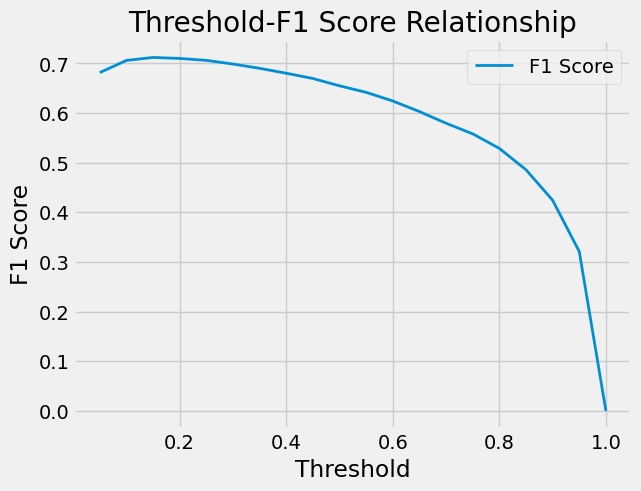

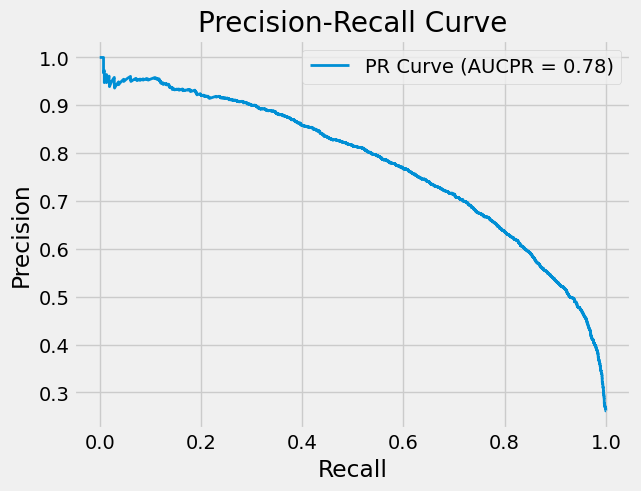

ROC Auc is 0.9064342270810094.


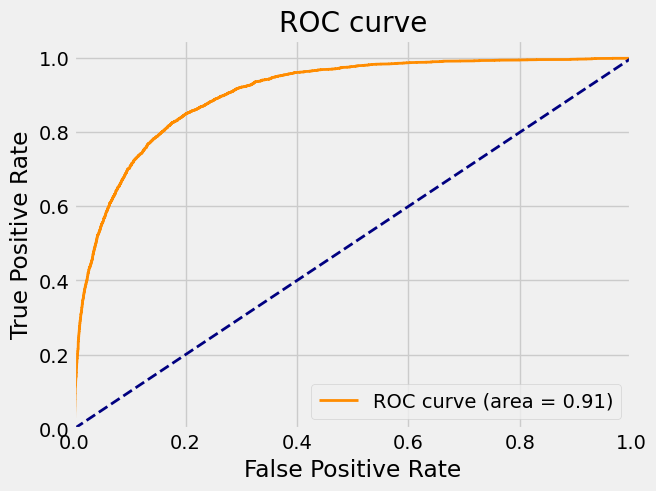

In [262]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test)**2)), 2)
    plt.title(f'RMSE is {rmse}.')
elif task == 'classification':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)
    
    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [263]:
# 将模型预测错误的样本保存到一个列表中
errors = []
trues = []
for i in range(len(y_test)):
    if preds[i] > 0.5 and y_test[i] == 0:
        errors.append(X_test[i])
        trues.append(0)
    elif preds[i] <= 0.5 and y_test[i] == 1:
        errors.append(X_test[i])
        trues.append(1)
# # 保存到文件中
# with open("error_samples.txt", "w") as f:
#     for sample in errors:
#         f.write(str(sample) + "\n")


In [264]:
trues.count(1)

1752

In [265]:
A = [1,2,3]
A.index(2)

1

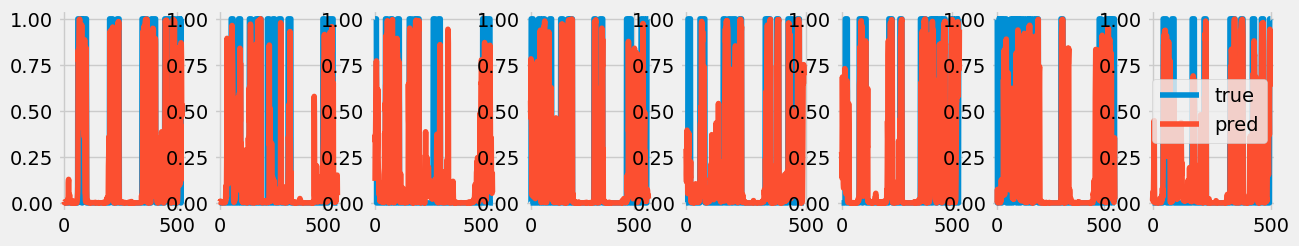

In [266]:
# visulized on many sample on validation data

sample_value = 8
samples = random.sample(split_time_test, sample_value)
fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()

In [267]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

['2023-04-01_qc03_#02_All.csv',
 '2023-04-17_qc03_exp3_#03_B3B8.csv',
 '2023-04-10_qc01_exp3_#01_All.csv',
 '2023-04-01_qc03_#05_B8.csv',
 '2023-04-17_qc03_exp4_#02_LTE3.csv',
 '2023-04-17_qc00_exp1_#02_All.csv',
 '2023-03-26_qc03_#03_All3.csv',
 '2023-04-17_qc02_exp4_#01_All2.csv']

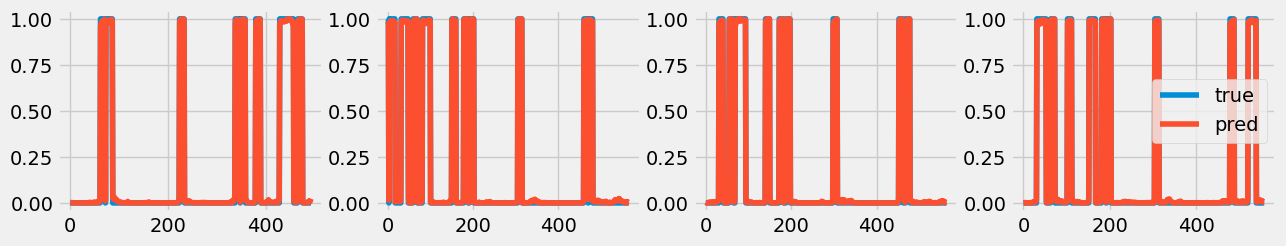

In [268]:
# Check whethet it do good on training data
sample_value = 4
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(train_data)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()

# grid search

## Search on task

In [269]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 30
predict_ts = list(range(1,31))
valid_ratio = 0.2
task = 'classification'

dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)

features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
            'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
target = ['LTE_HO', 'MN_HO'] # For eNB HO.

num_of_features = len(features)


for predict_t in predict_ts:
    print(f'predict_t {predict_t}')
    X_train, y_train, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
    X_train_2d = X_train.reshape(-1, time_seq*num_of_features)

    X_test, y_test, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
    X_test_2d = X_test.reshape(-1, time_seq*num_of_features)

    train_data = xgb.DMatrix(X_train_2d, label=y_train)
    test_data = xgb.DMatrix(X_test_2d, label=y_test)

    # Parameters
    if task == 'forecast':
        params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'max_depth': 20, 'eval_metric': ['rmse', 'mae'], 'seed': seed}
    elif task == 'classification':
        params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'max_depth': 20, 'eta': 0.1,
                'seed': seed,'eval_metric': ['error','logloss','aucpr']}
    n = 600

    model = xgb.train(
        params=params,
        dtrain=train_data,
        num_boost_round=n,
        evals=[(train_data, 'train'), (test_data, 'valid')],
        early_stopping_rounds=5,
        verbose_eval=False
    )

    preds = model.predict(test_data)

    # plot all data point on a plot
    ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

    if task == 'forecast':
        rmse = round(np.sqrt(np.mean((preds-y_test)**2)), 2)
        plt.title(f'RMSE is {rmse}.')
    elif task == 'classification':
        # PR and AUCPR
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        aucpr = auc(recall, precision)
        
        # ROC & AUC
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        roc_auc = auc(fpr, tpr)
        
        # Manually count
        for threshold in ths:
            TP, FP, TN, FN = 0,0,0,0
            anses = np.where(preds<threshold, 0, 1)
            for ans, y in zip(anses, y_test):
                if ans == y:
                    if ans == 1: TP += 1
                    elif ans == 0: TN +=1
                elif ans != y:
                    if ans == 1: FP += 1
                    elif ans == 0: FN +=1
            acc=(TP+TN)/(TP+TN+FP+FN)*100
            try:
                p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
                f1 = round(2*(p*r)/(p+r), 2)
            except:
                p, r, f1 = 'DNF', 'DNF', 'DNF'
            s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
            print(s)
        print('PR Curve (AUCPR = %0.2f)' % aucpr)
        print(f'ROC Auc is {roc_auc}.')
        print('============================================================')

predict_t 1


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 97.48043519755679; precision: 0.62; recall:0.39; f1:0.48
th: 0.3; Acc: 97.46134758541707; precision: 0.65; recall:0.31; f1:0.42
th: 0.4; Acc: 97.46771012279697; precision: 0.7; recall:0.25; f1:0.37
th: 0.5; Acc: 97.41680982375772; precision: 0.71; recall:0.21; f1:0.32
th: 0.6; Acc: 97.34045937519883; precision: 0.71; recall:0.17; f1:0.27
th: 0.7; Acc: 97.30228415091938; precision: 0.74; recall:0.13; f1:0.22
th: 0.8; Acc: 97.27047146401985; precision: 0.81; recall:0.1; f1:0.18
PR Curve (AUCPR = 0.49)
ROC Auc is 0.9481212853548313.
predict_t 2


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 95.25752167261601; precision: 0.64; recall:0.42; f1:0.51
th: 0.3; Acc: 95.34676185619581; precision: 0.69; recall:0.35; f1:0.46
th: 0.4; Acc: 95.34038755736869; precision: 0.73; recall:0.31; f1:0.44
th: 0.5; Acc: 95.34038755736869; precision: 0.79; recall:0.27; f1:0.4
th: 0.6; Acc: 95.19377868434472; precision: 0.81; recall:0.22; f1:0.35
th: 0.7; Acc: 95.07266700662927; precision: 0.84; recall:0.19; f1:0.31
th: 0.8; Acc: 94.88781234064253; precision: 0.85; recall:0.14; f1:0.24
PR Curve (AUCPR = 0.57)
ROC Auc is 0.9303431391924633.
predict_t 3


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 93.38399642378185; precision: 0.65; recall:0.5; f1:0.57
th: 0.3; Acc: 93.29459097004917; precision: 0.68; recall:0.41; f1:0.51
th: 0.4; Acc: 93.33290759307746; precision: 0.72; recall:0.35; f1:0.47
th: 0.5; Acc: 93.23072993166869; precision: 0.76; recall:0.3; f1:0.43
th: 0.6; Acc: 93.14771058177406; precision: 0.79; recall:0.26; f1:0.39
th: 0.7; Acc: 92.98167188198481; precision: 0.83; recall:0.22; f1:0.35
th: 0.8; Acc: 92.75815824765311; precision: 0.85; recall:0.18; f1:0.3
PR Curve (AUCPR = 0.60)
ROC Auc is 0.919982024694459.
predict_t 4


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 91.33717210492642; precision: 0.63; recall:0.54; f1:0.58
th: 0.3; Acc: 91.7658349328215; precision: 0.69; recall:0.48; f1:0.57
th: 0.4; Acc: 91.7402431222009; precision: 0.72; recall:0.42; f1:0.53
th: 0.5; Acc: 91.77223288547664; precision: 0.77; recall:0.37; f1:0.5
th: 0.6; Acc: 91.43314139475368; precision: 0.79; recall:0.31; f1:0.45
th: 0.7; Acc: 91.18362124120281; precision: 0.82; recall:0.27; f1:0.41
th: 0.8; Acc: 90.7485604606526; precision: 0.85; recall:0.21; f1:0.34
PR Curve (AUCPR = 0.64)
ROC Auc is 0.913445510427637.
predict_t 5


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 89.57118133452984; precision: 0.63; recall:0.58; f1:0.6
th: 0.3; Acc: 90.01346067559773; precision: 0.68; recall:0.51; f1:0.58
th: 0.4; Acc: 90.08396897634768; precision: 0.72; recall:0.46; f1:0.56
th: 0.5; Acc: 90.07114928530223; precision: 0.76; recall:0.4; f1:0.52
th: 0.6; Acc: 89.80193577334786; precision: 0.79; recall:0.35; f1:0.49
th: 0.7; Acc: 89.43016473302994; precision: 0.81; recall:0.3; f1:0.44
th: 0.8; Acc: 88.96865585539389; precision: 0.83; recall:0.24; f1:0.37
PR Curve (AUCPR = 0.66)
ROC Auc is 0.9085833556780052.
predict_t 6


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 88.61417929617261; precision: 0.66; recall:0.62; f1:0.64
th: 0.3; Acc: 88.87105060364757; precision: 0.69; recall:0.55; f1:0.61
th: 0.4; Acc: 88.8646288209607; precision: 0.72; recall:0.5; f1:0.59
th: 0.5; Acc: 88.8389416902132; precision: 0.75; recall:0.46; f1:0.57
th: 0.6; Acc: 88.65913177498074; precision: 0.79; recall:0.41; f1:0.54
th: 0.7; Acc: 88.20318520421269; precision: 0.8; recall:0.36; f1:0.5
th: 0.8; Acc: 87.82430002568714; precision: 0.83; recall:0.31; f1:0.45
PR Curve (AUCPR = 0.69)
ROC Auc is 0.9075596965267684.
predict_t 7


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 87.25471273241973; precision: 0.66; recall:0.64; f1:0.65
th: 0.3; Acc: 87.60856977417487; precision: 0.69; recall:0.59; f1:0.64
th: 0.4; Acc: 87.79514894164576; precision: 0.73; recall:0.54; f1:0.62
th: 0.5; Acc: 87.6536061249437; precision: 0.75; recall:0.5; f1:0.6
th: 0.6; Acc: 87.26758026121082; precision: 0.77; recall:0.45; f1:0.57
th: 0.7; Acc: 86.9137232194557; precision: 0.79; recall:0.4; f1:0.53
th: 0.8; Acc: 86.50196229814064; precision: 0.82; recall:0.34; f1:0.48
PR Curve (AUCPR = 0.70)
ROC Auc is 0.9013838829091072.
predict_t 8


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 86.50895964934897; precision: 0.68; recall:0.66; f1:0.67
th: 0.3; Acc: 87.08263503931933; precision: 0.72; recall:0.62; f1:0.67
th: 0.4; Acc: 87.11486399381204; precision: 0.74; recall:0.58; f1:0.65
th: 0.5; Acc: 86.90859868505866; precision: 0.77; recall:0.53; f1:0.63
th: 0.6; Acc: 86.50251385845044; precision: 0.78; recall:0.48; f1:0.59
th: 0.7; Acc: 86.0061879592626; precision: 0.81; recall:0.43; f1:0.56
th: 0.8; Acc: 85.43251256929226; precision: 0.83; recall:0.37; f1:0.51
PR Curve (AUCPR = 0.72)
ROC Auc is 0.9002291166062375.
predict_t 9


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 85.12754278333871; precision: 0.67; recall:0.69; f1:0.68
th: 0.3; Acc: 85.83144979011948; precision: 0.71; recall:0.64; f1:0.67
th: 0.4; Acc: 86.17371649983855; precision: 0.74; recall:0.6; f1:0.66
th: 0.5; Acc: 85.81853406522441; precision: 0.76; recall:0.55; f1:0.64
th: 0.6; Acc: 85.50855666774298; precision: 0.79; recall:0.5; f1:0.61
th: 0.7; Acc: 84.92734904746528; precision: 0.81; recall:0.44; f1:0.57
th: 0.8; Acc: 84.07491120439134; precision: 0.84; recall:0.37; f1:0.51
PR Curve (AUCPR = 0.74)
ROC Auc is 0.8958820665007405.
predict_t 10


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 84.71143892339545; precision: 0.69; recall:0.71; f1:0.7
th: 0.3; Acc: 85.38431677018633; precision: 0.73; recall:0.66; f1:0.69
th: 0.4; Acc: 85.50077639751554; precision: 0.75; recall:0.62; f1:0.68
th: 0.5; Acc: 85.31961697722568; precision: 0.77; recall:0.58; f1:0.66
th: 0.6; Acc: 85.14492753623189; precision: 0.8; recall:0.53; f1:0.64
th: 0.7; Acc: 84.51086956521739; precision: 0.82; recall:0.48; f1:0.61
th: 0.8; Acc: 83.55331262939958; precision: 0.84; recall:0.42; f1:0.56
PR Curve (AUCPR = 0.76)
ROC Auc is 0.8981212934946026.
predict_t 11


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 83.07512802229857; precision: 0.67; recall:0.74; f1:0.7
th: 0.3; Acc: 83.92428858494847; precision: 0.71; recall:0.68; f1:0.69
th: 0.4; Acc: 84.2678420950282; precision: 0.74; recall:0.64; f1:0.69
th: 0.5; Acc: 84.31969922862514; precision: 0.77; recall:0.59; f1:0.67
th: 0.6; Acc: 84.13819926103585; precision: 0.8; recall:0.55; f1:0.65
th: 0.7; Acc: 83.43812795747715; precision: 0.83; recall:0.49; f1:0.62
th: 0.8; Acc: 82.25189602644714; precision: 0.85; recall:0.41; f1:0.55
PR Curve (AUCPR = 0.76)
ROC Auc is 0.8912639956957132.
predict_t 12


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 82.72502922457463; precision: 0.68; recall:0.76; f1:0.72
th: 0.3; Acc: 83.42641901545656; precision: 0.72; recall:0.7; f1:0.71
th: 0.4; Acc: 83.6082608130926; precision: 0.75; recall:0.65; f1:0.7
th: 0.5; Acc: 83.55630601376802; precision: 0.77; recall:0.61; f1:0.68
th: 0.6; Acc: 83.29653201714508; precision: 0.8; recall:0.56; f1:0.66
th: 0.7; Acc: 82.78997272373036; precision: 0.83; recall:0.51; f1:0.63
th: 0.8; Acc: 81.63397843875828; precision: 0.84; recall:0.45; f1:0.59
PR Curve (AUCPR = 0.77)
ROC Auc is 0.8895447305146934.
predict_t 13


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 81.91814691912292; precision: 0.68; recall:0.77; f1:0.72
th: 0.3; Acc: 82.6924328193116; precision: 0.72; recall:0.72; f1:0.72
th: 0.4; Acc: 82.85509792439326; precision: 0.75; recall:0.67; f1:0.71
th: 0.5; Acc: 83.04378944628799; precision: 0.78; recall:0.63; f1:0.7
th: 0.6; Acc: 82.93968377903572; precision: 0.8; recall:0.59; f1:0.68
th: 0.7; Acc: 82.0938252326111; precision: 0.82; recall:0.53; f1:0.64
th: 0.8; Acc: 81.0332487474787; precision: 0.85; recall:0.47; f1:0.61
PR Curve (AUCPR = 0.79)
ROC Auc is 0.8879126707051642.
predict_t 14


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 80.95176010430248; precision: 0.68; recall:0.78; f1:0.73
th: 0.3; Acc: 82.04693611473273; precision: 0.72; recall:0.74; f1:0.73
th: 0.4; Acc: 82.52933507170795; precision: 0.75; recall:0.69; f1:0.72
th: 0.5; Acc: 82.45762711864407; precision: 0.78; recall:0.65; f1:0.71
th: 0.6; Acc: 82.28161668839635; precision: 0.8; recall:0.61; f1:0.69
th: 0.7; Acc: 81.83833116036506; precision: 0.82; recall:0.56; f1:0.67
th: 0.8; Acc: 80.71056062581486; precision: 0.85; recall:0.5; f1:0.63
PR Curve (AUCPR = 0.79)
ROC Auc is 0.8869002280200109.
predict_t 15


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 80.38011886878714; precision: 0.68; recall:0.8; f1:0.74
th: 0.3; Acc: 81.37286917902162; precision: 0.72; recall:0.75; f1:0.73
th: 0.4; Acc: 81.85618183005681; precision: 0.75; recall:0.71; f1:0.73
th: 0.5; Acc: 81.75821304944158; precision: 0.77; recall:0.67; f1:0.72
th: 0.6; Acc: 81.62758800862126; precision: 0.8; recall:0.63; f1:0.7
th: 0.7; Acc: 81.13774410554502; precision: 0.82; recall:0.58; f1:0.68
th: 0.8; Acc: 79.7988374371367; precision: 0.85; recall:0.5; f1:0.63
PR Curve (AUCPR = 0.80)
ROC Auc is 0.8843989730048847.
predict_t 16


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 79.55110587619421; precision: 0.68; recall:0.82; f1:0.74
th: 0.3; Acc: 80.89255333071588; precision: 0.72; recall:0.77; f1:0.74
th: 0.4; Acc: 81.5600052349169; precision: 0.75; recall:0.73; f1:0.74
th: 0.5; Acc: 81.5600052349169; precision: 0.78; recall:0.69; f1:0.73
th: 0.6; Acc: 81.21973563669677; precision: 0.8; recall:0.64; f1:0.71
th: 0.7; Acc: 80.72241853160581; precision: 0.83; recall:0.59; f1:0.69
th: 0.8; Acc: 79.48566941499804; precision: 0.85; recall:0.52; f1:0.65
PR Curve (AUCPR = 0.81)
ROC Auc is 0.8833375664963877.
predict_t 17


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 79.73513407198584; precision: 0.69; recall:0.83; f1:0.75
th: 0.3; Acc: 81.0332393627483; precision: 0.73; recall:0.78; f1:0.75
th: 0.4; Acc: 81.48560938831704; precision: 0.76; recall:0.74; f1:0.75
th: 0.5; Acc: 81.17747328394415; precision: 0.78; recall:0.69; f1:0.73
th: 0.6; Acc: 81.01357110076705; precision: 0.81; recall:0.66; f1:0.73
th: 0.7; Acc: 80.75788369501082; precision: 0.84; recall:0.61; f1:0.71
th: 0.8; Acc: 79.37454926899626; precision: 0.86; recall:0.55; f1:0.67
PR Curve (AUCPR = 0.82)
ROC Auc is 0.883769441549921.
predict_t 18


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 79.65712033631108; precision: 0.7; recall:0.84; f1:0.76
th: 0.3; Acc: 80.74750394114557; precision: 0.73; recall:0.8; f1:0.76
th: 0.4; Acc: 81.4306358381503; precision: 0.76; recall:0.77; f1:0.76
th: 0.5; Acc: 81.43720441408303; precision: 0.79; recall:0.73; f1:0.76
th: 0.6; Acc: 81.35838150289018; precision: 0.81; recall:0.69; f1:0.75
th: 0.7; Acc: 80.5307409353652; precision: 0.83; recall:0.64; f1:0.72
th: 0.8; Acc: 79.56516027325276; precision: 0.86; recall:0.58; f1:0.69
PR Curve (AUCPR = 0.83)
ROC Auc is 0.8856294947575248.
predict_t 19


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 78.74300756827904; precision: 0.7; recall:0.85; f1:0.77
th: 0.3; Acc: 80.13820335636723; precision: 0.73; recall:0.81; f1:0.77
th: 0.4; Acc: 80.65811122079631; precision: 0.76; recall:0.77; f1:0.76
th: 0.5; Acc: 80.70417900625205; precision: 0.78; recall:0.73; f1:0.75
th: 0.6; Acc: 80.49358341559724; precision: 0.8; recall:0.69; f1:0.74
th: 0.7; Acc: 79.97367555116814; precision: 0.83; recall:0.64; f1:0.72
th: 0.8; Acc: 78.7693320171109; precision: 0.85; recall:0.58; f1:0.69
PR Curve (AUCPR = 0.84)
ROC Auc is 0.8814586815136962.
predict_t 20


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 77.97046024001055; precision: 0.69; recall:0.86; f1:0.77
th: 0.3; Acc: 79.57272847158117; precision: 0.73; recall:0.82; f1:0.77
th: 0.4; Acc: 80.15956745351444; precision: 0.76; recall:0.79; f1:0.77
th: 0.5; Acc: 80.33759725702228; precision: 0.78; recall:0.75; f1:0.76
th: 0.6; Acc: 80.1068178821047; precision: 0.8; recall:0.71; f1:0.75
th: 0.7; Acc: 79.71778979295793; precision: 0.83; recall:0.66; f1:0.74
th: 0.8; Acc: 78.41223790056706; precision: 0.85; recall:0.59; f1:0.7
PR Curve (AUCPR = 0.84)
ROC Auc is 0.8793025225242677.
predict_t 21


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 78.4897932219066; precision: 0.71; recall:0.86; f1:0.78
th: 0.3; Acc: 79.54680583999472; precision: 0.74; recall:0.83; f1:0.78
th: 0.4; Acc: 80.33956530356082; precision: 0.77; recall:0.79; f1:0.78
th: 0.5; Acc: 80.6764880755764; precision: 0.79; recall:0.76; f1:0.77
th: 0.6; Acc: 80.47169188082182; precision: 0.81; recall:0.73; f1:0.77
th: 0.7; Acc: 79.75820836361234; precision: 0.83; recall:0.68; f1:0.75
th: 0.8; Acc: 78.37748563123472; precision: 0.85; recall:0.62; f1:0.72
PR Curve (AUCPR = 0.85)
ROC Auc is 0.8797141160517243.
predict_t 22


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 77.36298649722002; precision: 0.7; recall:0.88; f1:0.78
th: 0.3; Acc: 78.70002647603918; precision: 0.73; recall:0.84; f1:0.78
th: 0.4; Acc: 79.61344982790575; precision: 0.76; recall:0.81; f1:0.78
th: 0.5; Acc: 80.07678051363516; precision: 0.78; recall:0.77; f1:0.77
th: 0.6; Acc: 80.03044744506221; precision: 0.81; recall:0.73; f1:0.77
th: 0.7; Acc: 79.44135557320625; precision: 0.83; recall:0.68; f1:0.75
th: 0.8; Acc: 77.91236431029918; precision: 0.86; recall:0.62; f1:0.72
PR Curve (AUCPR = 0.85)
ROC Auc is 0.8763337421687355.
predict_t 23


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 77.05418131175807; precision: 0.7; recall:0.88; f1:0.78
th: 0.3; Acc: 78.80496054114995; precision: 0.74; recall:0.85; f1:0.79
th: 0.4; Acc: 79.69361363485642; precision: 0.76; recall:0.82; f1:0.79
th: 0.5; Acc: 80.09151800517276; precision: 0.79; recall:0.79; f1:0.79
th: 0.6; Acc: 80.08488626566749; precision: 0.81; recall:0.75; f1:0.78
th: 0.7; Acc: 79.54771536574043; precision: 0.83; recall:0.71; f1:0.77
th: 0.8; Acc: 78.42695138934943; precision: 0.86; recall:0.64; f1:0.73
PR Curve (AUCPR = 0.86)
ROC Auc is 0.8757317824047346.
predict_t 24


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 76.65116279069767; precision: 0.7; recall:0.89; f1:0.78
th: 0.3; Acc: 78.42524916943522; precision: 0.73; recall:0.86; f1:0.79
th: 0.4; Acc: 79.55481727574751; precision: 0.76; recall:0.84; f1:0.8
th: 0.5; Acc: 80.16611295681064; precision: 0.79; recall:0.8; f1:0.79
th: 0.6; Acc: 80.04651162790698; precision: 0.81; recall:0.77; f1:0.79
th: 0.7; Acc: 79.734219269103; precision: 0.83; recall:0.72; f1:0.77
th: 0.8; Acc: 78.67774086378738; precision: 0.86; recall:0.66; f1:0.75
PR Curve (AUCPR = 0.86)
ROC Auc is 0.8743969189782326.
predict_t 25


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 76.19998668530724; precision: 0.7; recall:0.9; f1:0.79
th: 0.3; Acc: 78.08401571133746; precision: 0.74; recall:0.87; f1:0.8
th: 0.4; Acc: 78.94281339458092; precision: 0.76; recall:0.83; f1:0.79
th: 0.5; Acc: 79.71506557486187; precision: 0.79; recall:0.8; f1:0.79
th: 0.6; Acc: 79.83489780973304; precision: 0.81; recall:0.77; f1:0.79
th: 0.7; Acc: 79.46874375873777; precision: 0.84; recall:0.73; f1:0.78
th: 0.8; Acc: 78.02409959390188; precision: 0.86; recall:0.66; f1:0.75
PR Curve (AUCPR = 0.87)
ROC Auc is 0.8737865355073615.
predict_t 26


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 75.34685165421558; precision: 0.7; recall:0.9; f1:0.79
th: 0.3; Acc: 77.42129135538954; precision: 0.73; recall:0.87; f1:0.79
th: 0.4; Acc: 78.18169690501601; precision: 0.76; recall:0.84; f1:0.8
th: 0.5; Acc: 78.83537886872999; precision: 0.78; recall:0.81; f1:0.79
th: 0.6; Acc: 79.12886872998934; precision: 0.81; recall:0.77; f1:0.79
th: 0.7; Acc: 79.08884738527215; precision: 0.83; recall:0.73; f1:0.78
th: 0.8; Acc: 77.83484525080043; precision: 0.86; recall:0.67; f1:0.75
PR Curve (AUCPR = 0.87)
ROC Auc is 0.8690202318324427.
predict_t 27


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 76.62233509322996; precision: 0.72; recall:0.9; f1:0.8
th: 0.3; Acc: 78.10599478714163; precision: 0.75; recall:0.87; f1:0.81
th: 0.4; Acc: 79.19534852636504; precision: 0.77; recall:0.85; f1:0.81
th: 0.5; Acc: 79.7233175165408; precision: 0.79; recall:0.82; f1:0.8
th: 0.6; Acc: 79.8101984896077; precision: 0.81; recall:0.79; f1:0.8
th: 0.7; Acc: 79.44262514201698; precision: 0.84; recall:0.75; f1:0.79
th: 0.8; Acc: 78.68074583973802; precision: 0.86; recall:0.7; f1:0.77
PR Curve (AUCPR = 0.87)
ROC Auc is 0.8729311516783052.
predict_t 28


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 75.70644167671085; precision: 0.71; recall:0.91; f1:0.8
th: 0.3; Acc: 77.6014463640016; precision: 0.75; recall:0.88; f1:0.81
th: 0.4; Acc: 78.99424132851212; precision: 0.77; recall:0.85; f1:0.81
th: 0.5; Acc: 79.44957814383287; precision: 0.8; recall:0.82; f1:0.81
th: 0.6; Acc: 79.52323556984064; precision: 0.82; recall:0.79; f1:0.8
th: 0.7; Acc: 79.24869425472077; precision: 0.84; recall:0.75; f1:0.79
th: 0.8; Acc: 78.1103522164189; precision: 0.86; recall:0.7; f1:0.77
PR Curve (AUCPR = 0.88)
ROC Auc is 0.8702783750037607.
predict_t 29


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 75.24320697752432; precision: 0.71; recall:0.92; f1:0.8
th: 0.3; Acc: 77.0479704797048; precision: 0.74; recall:0.89; f1:0.81
th: 0.4; Acc: 78.17510902381751; precision: 0.77; recall:0.86; f1:0.81
th: 0.5; Acc: 78.77893324387789; precision: 0.79; recall:0.83; f1:0.81
th: 0.6; Acc: 78.93995303589399; precision: 0.81; recall:0.79; f1:0.8
th: 0.7; Acc: 78.83260650788327; precision: 0.84; recall:0.75; f1:0.79
th: 0.8; Acc: 77.72559543777255; precision: 0.87; recall:0.7; f1:0.78
PR Curve (AUCPR = 0.88)
ROC Auc is 0.8682094530222241.
predict_t 30


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

th: 0.2; Acc: 75.96800215111588; precision: 0.72; recall:0.92; f1:0.81
th: 0.3; Acc: 77.66872815272923; precision: 0.75; recall:0.89; f1:0.81
th: 0.4; Acc: 78.76445280989513; precision: 0.77; recall:0.87; f1:0.82
th: 0.5; Acc: 79.17450927668727; precision: 0.8; recall:0.84; f1:0.82
th: 0.6; Acc: 79.5778435063189; precision: 0.82; recall:0.8; f1:0.81
th: 0.7; Acc: 79.2551761226136; precision: 0.84; recall:0.77; f1:0.8
th: 0.8; Acc: 78.17961817692928; precision: 0.86; recall:0.72; f1:0.78
PR Curve (AUCPR = 0.89)
ROC Auc is 0.8715909712458728.
